# Kaggle Competition - Titanic: Machine Learning from Disaster

## Introduction

The code in this notebook was created to participate in the `Titanic: Machine Learning from Disaster` competition on `kaggle.com` (https://www.kaggle.com/competitions/titanic). To complete the task, current knowledge, the book `Introduction to Machine Leaning with Python` by Sandra Guido and Andreas C. Müller as well as the input from the huge amount of submitted code available on `kaggle.com` were used. Hence, I would like to thank everyone who submitted their project. Especially the following projects were very helpful:

* https://www.kaggle.com/sinakhorami/titanic-best-working-classifier
* https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial
* https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

## Start of the project

### Import modules:

In [1]:
import numpy as np
import pandas as pd

In [48]:
import re

In [26]:
import matplotlib.pyplot as plt
# import matplotlib.ticker as FormatStrFormatter
import seaborn as sns

In [160]:
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

### Import data:

In [5]:
train_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")

In [6]:
print(list(train_dataset.columns))
print(list(test_dataset.columns))

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


Test dataset lacks the feature/variable to predict:
* `Survived`; binary: 0 = No, 1 = Yes

The dataset includes 9 independent features:
* `PassengerId`: the passenger's ID
* `Name`: the passenger's full name
* `Sex`: the passenger's sex
* `Age`: the passenger's age
* `Pclass`: the passenger's ticket class
* `Ticket`: ticket number
* `Fare`: ticker fare
* `Cabin`: cabin number
* `SibSp`: number of siblings/spouses of the passenger aboard the Titanic
* `Parch`: number of parents/children of the passenger aboard the Titanic
* `Embarked`: port of embarkation

Combine the independent features of both training and test dataset to a complete dataset:

In [7]:
complete_dataset = pd.concat([train_dataset, test_dataset], axis = 0)

In [9]:
# complete_dataset

## Exploratory Data Analysis

In the following, the datasets (training and test subsets) and its features are examined. This examination will include descriptive elements, data cleaning as well as feature engineering. I do begin with looking at the dependent feature. 

### Dependent feature `Survived`

In [10]:
pd.DataFrame([complete_dataset["Survived"].value_counts(ascending = False), 
              round(complete_dataset["Survived"].value_counts(ascending = False, normalize = True) * 100, 0)],
            index = ["Count", "Pct."]).T

,Count,Pct.
0.0,549.0,62.0
1.0,342.0,38.0


The majority of passengers (appr. 62 percent) did not survive the Titanic shipwreck. The label imbalance could lead to potential problems when evaluating the models' performances. I will keep that in mind.

### Independent features

Inspect the independent features with regards to their missing values:

In [11]:
missings_total = complete_dataset.isna().sum().sort_values(ascending = False)
missings_pct = round(missings_total / len(complete_dataset) * 100, 1)
missings = pd.concat([missings_total, missings_pct], axis = 1, keys = ["Total", "Pct"])

In [12]:
missings[(missings["Pct"] > 0) & (missings.index != "Survived")]

,Total,Pct
Cabin,1014,77.5
Age,263,20.1
Embarked,2,0.2
Fare,1,0.1


The feature `Cabin` lacks a lot of data points as almost 80 percent are missing values. Therefore, one has to decide whether to drop the feature or to search for appropriate replacement values. `Age` has 20 percent of its values missing, which is uncritical and easy to handle (e.g. by imputing the missing values with the median age). The missings for features `Embarked` and `Fare` are not worth mentioning.

#### Cabin

In [13]:
complete_dataset["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

The feature contains strings which represent the cabin number. As stated on Wikipedia (`https://en.wikipedia.org/wiki/Titanic`), the letter indicates the **deck** on which the cabin was located.

One potential idea to impute the missing values is to use the `Pclass` feature, which shows to which price class (first, second or third) the passengers belonged to. It could be argued that the price class directly relates to the cabin and its position on the ship. According to the Wikipedia article, however, some of the decks (e.g. the D and E deck) were shared by passengers of all price classes. This is also evident in the data. First, a new feature called **Deck** is created: 

In [16]:
complete_dataset["Deck"] = complete_dataset["Cabin"].apply(lambda row: row[0] if isinstance(row, str) else row)

Next, I do look at the mean price class for each deck to check whether the **Deck** feature can be used to approximate the cabin (position):

In [19]:
complete_dataset[["Deck", "Pclass"]].groupby("Deck", as_index = False).mean()

,Deck,Pclass
0,A,1.000000
1,B,1.000000
2,C,1.000000
3,D,1.130435
4,E,1.243902
5,F,2.380952
6,G,3.000000
7,T,1.000000


The mean values for the decks D, E and F indicate that these decks were shared by at least two price classes. Hence, we will drop the newly created "Deck" as well as the "Cabin" features (after finishing the examination of all features). 

#### Pclass

As already stated, this feature contains information on the price class the passengers belonged to:

In [20]:
complete_dataset["Pclass"].value_counts(sort = False, normalize = True) * 100

1    24.675325
2    21.161192
3    54.163484
Name: Pclass, dtype: float64

As expected, most of the passengers were travelling in third class (appr. 54 percent). Next, I do examine the relation between `Pclass` and `Survived`:

In [16]:
complete_dataset[["Pclass", "Survived"]].groupby("Pclass", as_index = False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


The results indicate that the price class has a huge impact on the survival. While most of the first class passengers (appr. 63 percent) survived, three quarters of all third class passenger did not survive the shipwreck. In the following, binary encoded dummy variables for each price class are created (*since the current ordering does not make sense from my point of view. The first class is the best class but receives a value of 1.*):

In [21]:
complete_dataset["First_Class"] = complete_dataset["Pclass"].apply(lambda row: 1 if row == 1 else 0)
complete_dataset["Second_Class"] = complete_dataset["Pclass"].apply(lambda row: 1 if row == 2 else 0)
complete_dataset["Third_Class"] = complete_dataset["Pclass"].apply(lambda row: 1 if row == 3 else 0)

#### Age

This features contains the age (in years) of the passengers. As indicated on the competition webpage on `kaggle.com`, the age for passengers younger than 1 year is expressed as fraction. The missing values wil be imputed with the median (differentiated by sex):

In [22]:
complete_dataset["Age"] = complete_dataset.groupby("Sex")["Age"].transform(lambda x: x.fillna(x.median()))

Following, we examine the distribution:

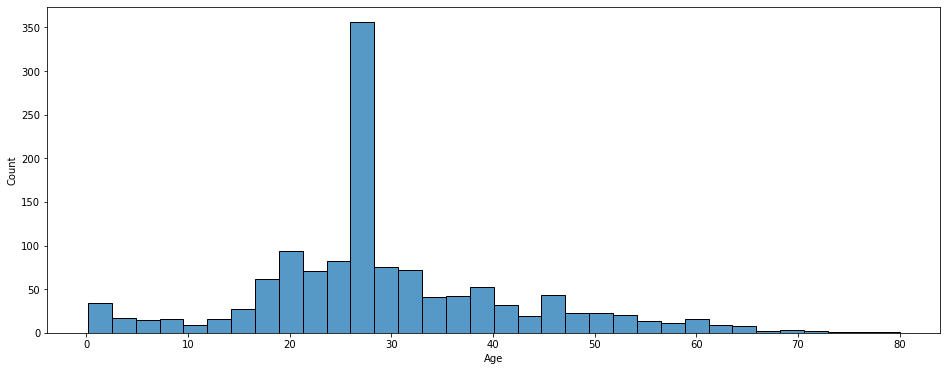

In [27]:
fig, ax = plt.subplots(figsize = (16, 6))
sns.histplot(data = complete_dataset, x = "Age", ax = ax)
plt.show()

Because of the replacement of missing values we created a huge peak in the distribution. To avoid problems related to the distribution, the feature will be converted to a categorical feature. To do so, the feature is divided into five different age brackets: 

In [28]:
complete_dataset["Age_Brackets"] = pd.cut(complete_dataset["Age"], 5, precision = 0)

In [29]:
complete_dataset.groupby("Age_Brackets")["Age_Brackets"].count()

Age_Brackets
(0.1, 16.0]     134
(16.0, 32.0]    787
(32.0, 48.0]    269
(48.0, 64.0]    106
(64.0, 80.0]     13
Name: Age_Brackets, dtype: int64

The majority of passengers were between 16 and 48 years old. Next, the relationship between the age brackets and the survival is examined:

In [30]:
complete_dataset[["Age_Brackets", "Survived"]].groupby("Age_Brackets").mean()

,Survived
Age_Brackets,
"(0.1, 16.0]",0.550000
"(16.0, 32.0]",0.344168
"(32.0, 48.0]",0.404255
"(48.0, 64.0]",0.434783
"(64.0, 80.0]",0.090909


The results indicate that differences in age do have an impact on the survival. To complete the feature's conversion to a categorical variable, the age brackets are translated to dummy values (0 to 4):

In [31]:
complete_dataset["Age_Cat"] = 0

In [32]:
complete_dataset.loc[(complete_dataset["Age"] > 16) & (complete_dataset["Age"] <= 32), "Age_Cat"] = 1
complete_dataset.loc[(complete_dataset["Age"] > 32) & (complete_dataset["Age"] <= 48), "Age_Cat"] = 2
complete_dataset.loc[(complete_dataset["Age"] > 48) & (complete_dataset["Age"] <= 64), "Age_Cat"] = 3
complete_dataset.loc[complete_dataset["Age"] > 64, "Age_Cat"] = 4

Final check for missing values:

In [33]:
complete_dataset["Age_Cat"].isna().sum()

0

#### Embarked

The features contains information on the port of embarkation. Impute the few missing values with the mode value ("S"):

In [34]:
complete_dataset["Embarked"].mode()[0]

'S'

In [35]:
complete_dataset["Embarked"] = complete_dataset["Embarked"].fillna(complete_dataset["Embarked"].mode()[0])

Check for missings:

In [36]:
complete_dataset["Embarked"].isna().sum()

0

Convert the feature to a categorical variable by creating binary encoded features for each class (*see Pclass for a brief explanation*):

In [37]:
complete_dataset["Embarked_S"] = complete_dataset["Embarked"].apply(lambda row: 1 if row == "S" else 0)
complete_dataset["Embarked_C"] = complete_dataset["Embarked"].apply(lambda row: 1 if row == "C" else 0)
complete_dataset["Embarked_Q"] = complete_dataset["Embarked"].apply(lambda row: 1 if row == "Q" else 0)

#### Fare

Feature shows the ticket prices. Impute the few missing values with the median value for the corresponding ticket class:

In [38]:
complete_dataset["Fare"] = complete_dataset.groupby("Pclass")["Fare"].transform(lambda x: x.fillna(x.median()))

Next, I do examine the distribution:

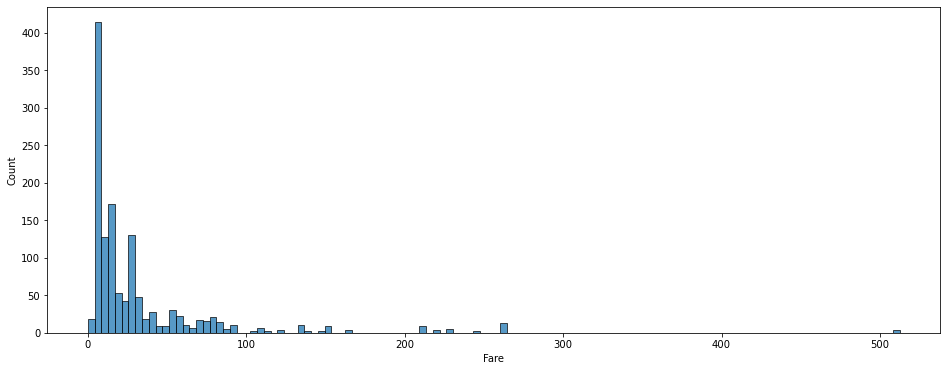

In [39]:
fig, ax = plt.subplots(figsize = (16, 6))
sns.histplot(data = complete_dataset, x = "Fare", ax = ax)
plt.show()

As expected, the feature's distribution is right-skewed. As for the `Age`-feature, the feature is converted to a categorical variable. First: create a new column with four fare brackets.

In [40]:
complete_dataset["Fare_Brackets"] = pd.cut(complete_dataset["Fare"], 4, precision = 0)

In [41]:
complete_dataset.groupby("Fare_Brackets")["Fare_Brackets"].count()

Fare_Brackets
(-1.0, 128.0]     1242
(128.0, 256.0]      50
(256.0, 384.0]      13
(384.0, 512.0]       4
Name: Fare_Brackets, dtype: int64

In the following, the relationship between the fare brackets and the survival is examined:

In [42]:
complete_dataset[["Fare_Brackets", "Survived"]].groupby("Fare_Brackets", as_index = False).mean()

,Fare_Brackets,Survived
0,"(-1.0, 128.0]",0.368113
1,"(128.0, 256.0]",0.724138
2,"(256.0, 384.0]",0.666667
3,"(384.0, 512.0]",1.000000


There is a clear relationship between a survival and the ticket price. One might argue that a higher ticket price is accompanied with e.g. a cabin closely located to the lifeboats. To complete the conversion to a categorical feature, translate the fare brackets to dummy values:

In [43]:
complete_dataset["Fare_Cat"] = 0

In [44]:
complete_dataset.loc[(complete_dataset["Fare"] > 128) & (complete_dataset["Fare"] <= 256), "Fare_Cat"] = 1
complete_dataset.loc[(complete_dataset["Fare"] > 256) & (complete_dataset["Fare"] <= 384), "Fare_Cat"] = 2
complete_dataset.loc[complete_dataset["Fare"] > 384, "Fare_Cat"] = 3

Final check for missing values:

In [45]:
complete_dataset["Fare_Cat"].isna().sum()

0

#### Ticket

Feature will be dropped since it only contains the string-formatted ticket number.

#### PassengerId

Features contains the passengers' ID. Convert it to a string since no calculation can be applied to the ID:

In [46]:
complete_dataset["PassengerId"] = complete_dataset["PassengerId"].astype("str")

#### Name

This feature encompasses the passengers' first and second name as well as their title. I do create a new column with the title to check whether it has an impact on the survival:

In [49]:
complete_dataset["Title"] = complete_dataset["Name"].apply(lambda row: re.findall(r'\w+\.', row)[0])

In [50]:
complete_dataset["Title"].value_counts()

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Rev.           8
Dr.            8
Col.           4
Mlle.          2
Major.         2
Ms.            2
Mme.           1
Don.           1
Sir.           1
Jonkheer.      1
Capt.          1
Lady.          1
Dona.          1
Countess.      1
Name: Title, dtype: int64

Replace 'Miss.' with 'Ms.':

In [51]:
complete_dataset["Title"] = complete_dataset["Title"].replace("Miss.", "Ms.")

Summarize all classes with count < 10 to one category to remove the noise:

In [54]:
count_less_ten = complete_dataset.groupby("Title")["Title"].count()
count_less_ten = list(count_less_ten[count_less_ten < 10].index)

In [55]:
complete_dataset["Title"] = complete_dataset["Title"].replace(count_less_ten, "Rest")

Next, the relation between survival and the passengers' title is examined:

In [56]:
complete_dataset[["Title", "Survived"]].groupby("Title", as_index = False).mean()

,Title,Survived
0,Master.,0.575000
1,Mr.,0.156673
2,Mrs.,0.792000
3,Ms.,0.699454
4,Rest,0.423077


The table indicates that the title does have an impact on the survival. Higher survival rates are related to female titles. That makes sense as women and children were saved first. As for the features `Pclass` and `Embarked`, binary encoded features for each class are created:

In [57]:
complete_dataset["Title_Mrs"] = complete_dataset["Title"].apply(lambda row: 1 if row == "Mrs." else 0)
complete_dataset["Title_Ms"] = complete_dataset["Title"].apply(lambda row: 1 if row == "Ms." else 0)
complete_dataset["Title_Mr"] = complete_dataset["Title"].apply(lambda row: 1 if row == "Mr." else 0)
complete_dataset["Title_Master"] = complete_dataset["Title"].apply(lambda row: 1 if row == "Master." else 0)
complete_dataset["Title_Rest"] = complete_dataset["Title"].apply(lambda row: 1 if row == "Rest" else 0)

#### Sex

The features contains information on the passengers' sex. In this dataset, it makes sense ti differentiate between female and male. Hence, a binary variable with two classes is created: 0 (male) and 1 (female). 

In [58]:
complete_dataset["Sex"].value_counts()

male      843
female    466
Name: Sex, dtype: int64

In [59]:
complete_dataset["Sex"] = complete_dataset["Sex"].apply(lambda row: 0 if row == "male" else 1)

As expected, the table above shows that most of the passengers were male persons. Following, I do look at the survival rates of both sexes:

In [60]:
complete_dataset[["Sex", "Survived"]].groupby("Sex", as_index = False).mean()

,Sex,Survived
0,0,0.188908
1,1,0.742038


As already seen for the `Title`-feature, female persons have the higher rate of survival.

#### SibSp & Parch

Both features contain information on the family size. Hence, features are combined in one single feature:

In [61]:
complete_dataset["FamSize"] = complete_dataset["SibSp"] + complete_dataset["Parch"] + 1

In [62]:
complete_dataset.groupby("FamSize")["FamSize"].count()

FamSize
1     790
2     235
3     159
4      43
5      22
6      25
7      16
8       8
11     11
Name: FamSize, dtype: int64

Next, the relationship between the passengers' family size and the survival is examined:

In [63]:
complete_dataset[["FamSize", "Survived"]].groupby("FamSize", as_index = False).mean()

,FamSize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


There are definitely differences in survival related to the family size. However, family sizes greater than 3 could be summarized to one group. Moreover, the feature is converted to a categorical variable:

In [64]:
complete_dataset["FamSize"] = complete_dataset["FamSize"].apply(lambda row: "4+" if row >= 4 else row)
complete_dataset["FamSize"] = complete_dataset["FamSize"].astype("str")

In [65]:
complete_dataset["FamSize_Cat"] = 0

In [66]:
complete_dataset.loc[complete_dataset["FamSize"] == "2", "FamSize_Cat"] = 1
complete_dataset.loc[complete_dataset["FamSize"] == "3", "FamSize_Cat"] = 2
complete_dataset.loc[complete_dataset["FamSize"] == "4+", "FamSize_Cat"] = 3

Again, the relationship between feature and survival is examined:

In [67]:
complete_dataset[["FamSize_Cat", "Survived"]].groupby("FamSize_Cat", as_index = False).mean()

,FamSize_Cat,Survived
0,0,0.303538
1,1,0.552795
2,2,0.578431
3,3,0.340659


The results show an increasing chance of survival for passengers that did not travel alone. However, there is a reverse in this relation for the last category (family size of 4 or greater).

As indicated above, not required features are dropped:

In [68]:
complete_dataset.drop(columns = ["Deck", "Cabin", "Pclass", "Age", "Age_Brackets", "Embarked",
                                 "Fare", "Fare_Brackets", "Ticket", "Name", "Title", "SibSp", "Parch",
                                 "FamSize"], axis = 1, inplace = True)

Inspect the final dataset:

In [69]:
complete_dataset.head()

,PassengerId,Survived,Sex,First_Class,Second_Class,Third_Class,Age_Cat,Embarked_S,Embarked_C,Embarked_Q,Fare_Cat,Title_Mrs,Title_Ms,Title_Mr,Title_Master,Title_Rest,FamSize_Cat
0,1,0.0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1
1,2,1.0,1,1,0,0,2,0,1,0,0,1,0,0,0,0,1
2,3,1.0,1,0,0,1,1,1,0,0,0,0,1,0,0,0,0
3,4,1.0,1,1,0,0,2,1,0,0,0,1,0,0,0,0,1
4,5,0.0,0,0,0,1,2,1,0,0,0,0,0,1,0,0,0


In [70]:
print(list(complete_dataset.columns))

['PassengerId', 'Survived', 'Sex', 'First_Class', 'Second_Class', 'Third_Class', 'Age_Cat', 'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Fare_Cat', 'Title_Mrs', 'Title_Ms', 'Title_Mr', 'Title_Master', 'Title_Rest', 'FamSize_Cat']


In [71]:
print(complete_dataset.shape)

(1309, 17)


After exploring the dataset 16 explanatory features (17 minus 1 as the passenger ID will not be used) for predicting the survival are left. In the following, the data is prepared to build machine learning models. 

## Dataset preparation

First move: split the complete dataset to a training and test dataset again. Moreover, save the dependent and independent features in separated objects:

In [72]:
X_train = complete_dataset.iloc[:train_dataset.shape[0], :].copy()
X_train.drop(columns = ["PassengerId", "Survived"], axis = 1, inplace = True)

In [73]:
y = complete_dataset.iloc[:train_dataset.shape[0], 1].copy()

In [74]:
X_test = complete_dataset.iloc[train_dataset.shape[0]:, :].copy()
X_test.drop(columns = ["PassengerId", "Survived"], axis = 1, inplace = True)

Save the `PassengerId` of the test dataset for the final submission:

In [75]:
test_passengerid = complete_dataset.iloc[train_dataset.shape[0]:, 0].copy()

## Modelling

Before starting with models, a validation strategy is defined. I will use a Stratified K-Fold Cross Validation with five folds:

In [78]:
strat_cv_folds = StratifiedKFold(n_splits = 5, random_state = 69, shuffle = True)

Since the dependent feauture suffers from label imbalance, one cannot simply rely on accuracy. Hence, I will primarily use the F1-score for evaluation:

In [79]:
def model_f1_score(model, X = X_train, y = y):
    model_acc = cross_val_score(model, X, y, cv = strat_cv_folds, scoring = "f1")
    return model_acc

Finally, an empty dictionary is created to store all the models' accuracy scores:

In [80]:
model_scores = {}

### Dummy Classifier:

My first model is a Dummy Classifier, which ignores the input data and therefore makes predictions without finding patterns in the data. By setting the parameter `strategy` the classifier will always predict the most frequent class (0, not survived in our case).

In [84]:
dummy_class = DummyClassifier(strategy = "most_frequent", random_state = 69)

In [85]:
model_f1_score(dummy_class).mean()

0.0

The F1-Score is equal to zero (the reasons are discussed after making predictions).

In [86]:
dummy_class_fitted = DummyClassifier(strategy = "most_frequent", random_state = 69).fit(X_train, y)

In [87]:
dummy_class_pred = dummy_class_fitted.predict(X_train)

Lets take a look at the confusion matrix:

In [90]:
print(confusion_matrix(y, dummy_class_pred))

[[549   0]
 [342   0]]


Explanation of the structure of the confusion matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

For binary classifications, the confusion matrix is a 2x2 matrix:
    
    [[true negative   false positive]
     [false negative  true positive]]

The confusion matrix shows that the dummy classifier always predict the most frequent class (0) since the value in the upper left corner is equal to the number of data points belonging to the negative class. Moreover, is classifies 342 false negatives, 0 false positives and of course 0 true positives. Despite that nonsensical results, the model would achieve a quite good accuracy:

In [93]:
round(accuracy_score(y, dummy_class_pred), 2) * 100

62.0

It is possible to set `strategy` to "stratified" to control for the proportions of classes in the data. However, "most_frequent" is used to show that the label imbalance in the dependent features makes accucary a poor choice when it comes to model evaluation. The score is not saved as a comparison with the other models is redundant.

In [94]:
print(classification_report(y, dummy_class_pred, zero_division = 0))

              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76       549
         1.0       0.00      0.00      0.00       342

    accuracy                           0.62       891
   macro avg       0.31      0.50      0.38       891
weighted avg       0.38      0.62      0.47       891



### K-Neighbors Classifier

The first "real" model is the simple K-Neighbors Classifier (without parameter tuning). The number of neighbors is set to the default value of 5:

In [96]:
k_neighs = KNeighborsClassifier(n_jobs = -1)

In [97]:
model_f1_score(k_neighs).mean()

0.726755792568049

Following, the model is fitted. Using the model, I do make predictions:

In [98]:
k_neighs_fitted = k_neighs.fit(X_train, y)

In [99]:
k_neighs_pred = k_neighs_fitted.predict(X_train)

Before examining the F1-Score, the already known confusion matrix is generated again:

In [100]:
print(confusion_matrix(y, k_neighs_pred))

[[497  52]
 [ 86 256]]


We see that the model does perform better on a large scale compared to the Dummy Classifier. However, false positives and false negatives seem to be quite high. I assume other models could improve on that. Next, the F1-Score is saved for model comparisons:

In [101]:
model_scores["K-Neighbors"] = f1_score(y, k_neighs_pred)

In [102]:
round(model_scores["K-Neighbors"], 3) * 100

78.8

Since the Dummy Classifier is dismissed for further comparions, the K-Neighbors Classifier will serve as baseline model.

### Logistic Regression

The next model is a Logistic Regression, which is a linear model for classification. I do start with a plain model without parameter tuning:

In [103]:
log_reg = LogisticRegression(random_state = 69, max_iter = 100000, n_jobs = -1)

In [104]:
model_f1_score(log_reg).mean()

0.7484412478275452

Fitting and predicting:

In [105]:
log_reg_fitted = log_reg.fit(X_train, y)

In [106]:
log_reg_pred = log_reg_fitted.predict(X_train)

How does the confusion matrix look like?

In [107]:
print(confusion_matrix(y, log_reg_pred))

[[487  62]
 [ 95 247]]


The confusion matrices of both K-Neighbors and Logistic Regression do look almost identical. Does the same apply for the F1-Score?

In [108]:
model_scores["LogReg"] = f1_score(y, log_reg_pred)

In [109]:
round(model_scores["LogReg"], 3) * 100

75.9

Compared to the K-Neighbors model the Logistic Regression yields a slightly lower F1-Score.

### Linear Support Vector Classifier

Similar to the Logistic Regression, the Linear Support Vector Classifier belongs to the class of linear models.

In [110]:
support_vc = LinearSVC(random_state = 69, max_iter = 100000)

In [111]:
model_f1_score(support_vc).mean()

0.7557589236456409

Next, predictions are generated:

In [112]:
support_vc_fitted = support_vc.fit(X_train, y)

In [113]:
support_vc_pred = support_vc_fitted.predict(X_train)

In [114]:
print(confusion_matrix(y, support_vc_pred))

[[486  63]
 [ 87 255]]


See comments on the confusion matrix for the Logistic Regression.

In [115]:
model_scores["SVC"] = f1_score(y, support_vc_pred)

In [116]:
round(model_scores["SVC"], 3) * 100

77.3

F1-Score is almost the same as for the K-Neighbors Classifier.

### (Gaussian) Naive Bayes

Before turning to tree-based models, a (Gaussian) Naive Bayes Classifer is fitted to the data:

In [117]:
naive_bayes = GaussianNB()

In [118]:
model_f1_score(naive_bayes).mean()

0.7229812932530774

Predictions and confusion matrix:

In [119]:
naive_bayes_fitted = naive_bayes.fit(X_train, y)

In [120]:
naive_bayes_pred = naive_bayes_fitted.predict(X_train)

In [121]:
print(confusion_matrix(y, naive_bayes_pred))

[[433 116]
 [ 79 263]]


The Naive Bayes Classifies tends to produce more false positives relative to the other models. That should be reflected in a lower F1-Score.

In [122]:
model_scores["NaiveBayes"] = f1_score(y, naive_bayes_pred)

In [123]:
round(model_scores["NaiveBayes"], 3) * 100

73.0

As assumed, this model yiels the lowest F1-Score (up to this point of our examination).

### Decision Tree Classifier

After using neighbors and linear relations for classfication, we turn to tree-based classifier. First in line: the Decision Tree. As for the previous model, I do create a "naked" model:

In [124]:
dec_tree = DecisionTreeClassifier(random_state = 69)

In [125]:
model_f1_score(dec_tree).mean()

0.7039989973793442

Next, predictions are generated and the confusion matrix is examined:

In [126]:
dec_tree_fitted = DecisionTreeClassifier(random_state = 69).fit(X_train, y)

In [127]:
dec_tree_pred = dec_tree_fitted.predict(X_train)

In [128]:
print(confusion_matrix(y, dec_tree_pred))

[[530  19]
 [103 239]]


The Decision Tree is able to classify almost all of the negative classes. However, it produces a lot of false negatives.

In [129]:
model_scores["DecTree"] = f1_score(y, dec_tree_pred)

In [130]:
round(model_scores["DecTree"], 3) * 100

79.7

Despite the large fraction of false negatives, the F1-Score is the highest compared to all introduced models.

### Random Forest Classifier

The next tree-based classifer is the Random Forest. Lets start with a model without parameter tuning:

In [131]:
random_forest = RandomForestClassifier(random_state = 69, n_jobs = -1)

In [132]:
model_f1_score(random_forest).mean()

0.711814738292011

Next, predictions are generated and the confusion matrix is examined:

In [133]:
random_forest_fitted = RandomForestClassifier(random_state = 69, n_jobs = -1).fit(X_train, y)

In [134]:
random_forest_pred = random_forest_fitted.predict(X_train)

In [135]:
print(confusion_matrix(y, random_forest_pred))

[[524  25]
 [ 97 245]]


Results are similar to that of the single Decision Tree. 

In [136]:
model_scores["RandForest"] = f1_score(y, random_forest_pred)

In [137]:
round(model_scores["RandForest"], 3) * 100

80.10000000000001

The Random Forest yields almost the same F1-score as the single Decision Tree.

### Extreme Gradient Boosting

Lastly, we utilize the Extreme Gradient Boosting model.

In [138]:
xgb_class = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = "logloss", random_state = 69, n_jobs = -1,
                             use_label_encoder = False)

In [139]:
model_f1_score(xgb_class).mean()

0.7234486131709319

Already known procedure: make predictions, inspect confusion matrix and save the F1-Score.

In [140]:
xgb_class_fitted = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = "logloss", random_state = 69, n_jobs = -1,
                             use_label_encoder = False).fit(X_train, y)

In [141]:
xgb_class_pred = xgb_class_fitted.predict(X_train)

In [142]:
print(confusion_matrix(y, xgb_class_pred))

[[521  28]
 [ 95 247]]


Basically the same as observed for the Random Forest.

In [143]:
model_scores["XGB"] = f1_score(y, xgb_class_pred)

In [144]:
round(model_scores["XGB"], 3) * 100

80.10000000000001

See comment on the confusion matrix for the random forest.

### Model comparison

In the following, models are compared with respect to their F1-Scores. The model with the highest score will be used to generate predictions using the test dataset. 

In [145]:
model_scores = dict(sorted(model_scores.items(), key = lambda x: x[1], reverse = False))

In [146]:
print(f"Model with the highest F1-Score: {list(model_scores.keys())[-1]}")
print(f"F1-Score: {round(list(model_scores.values())[-1], 2) * 100} %")

Model with the highest F1-Score: RandForest
F1-Score: 80.0 %


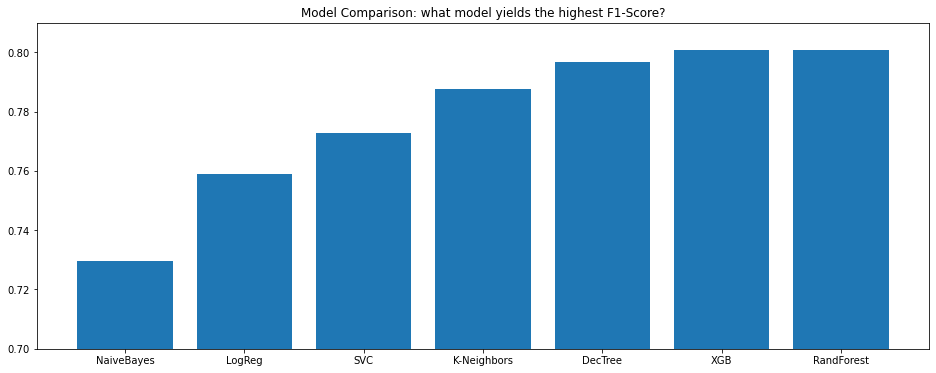

In [147]:
plt.figure(figsize = (16, 6))
plt.bar(model_scores.keys(), model_scores.values())
plt.title("Model Comparison: what model yields the highest F1-Score?")
plt.ylim(0.70, 0.81)
plt.show()

As indicated by the chart, the tree-based models do outperform all other models. Altough the performance of all tree-based classifier is almost equal, the Random Forest will be my final model. The choice is mainly driven by two arguments:
* It is easier to tune relative to the XGB. Before predicting the final results using the test data, I will try to optimize the Random Forest model by tuning the hyperparameters. To do so, the handy GridSeachCV package is used.
* The Random Forest is less prone to overfitting when compared to a single Decision Tree. This increases the probability of more generalized predictions.

### Parameter tuning

For hyperparameter tuning a dictionary object with all parameters we want to tune is created. According to `Introduction to Machine Leaning with Python` by Sandra Guido and Andreas C. Müller, the Random Forest Classifier's most important parameters are `n_estimators` and `max_features`. Hence, both parameters will be tuned: 

In [148]:
rnd_forest_params = {'n_estimators': [100, 250, 500, 1000, 2000, 3000], 'max_features': [None, "sqrt", "log2"]}

In [149]:
random_forest_GS = GridSearchCV(random_forest, param_grid = rnd_forest_params, cv = strat_cv_folds, scoring = "f1")

In [150]:
random_forest_GS_fitted = random_forest_GS.fit(X_train, y)

The results are examined to choose the best parameters:

In [151]:
gs_results = pd.DataFrame(random_forest_GS_fitted.cv_results_)

In [152]:
# gs_results.T

In [153]:
gs_mean_scores = np.array(gs_results.mean_test_score).reshape(3, 6)

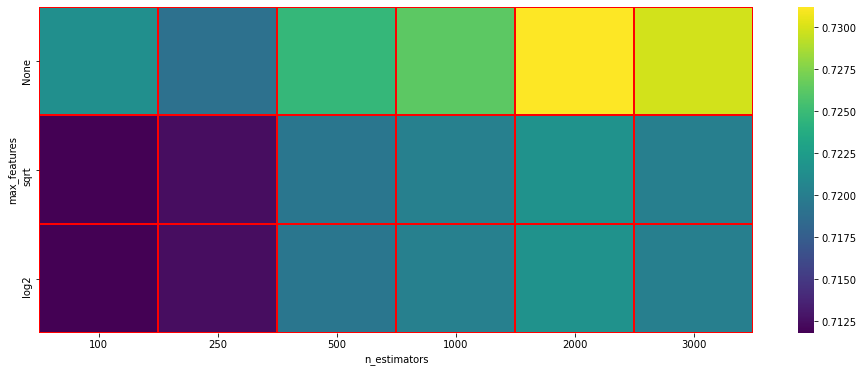

In [154]:
fig, ax = plt.subplots(figsize = (16, 6))
sns.heatmap(gs_mean_scores, xticklabels = rnd_forest_params["n_estimators"],
            yticklabels = ["None"] + rnd_forest_params["max_features"][1:],
            linecolor = "red", linewidths = 1, cmap = "viridis", ax = ax)
ax.set_xlabel("n_estimators")
ax.set_ylabel("max_features")
plt.show()

As indicated, an increasing number of estimators and `max_features` set to `None` yield the best results. However, the examination of the result dataframe shows that the increase in the mean score between `n_estimators` equal to 2,000 and 3,000 is marginal. Considerung the computational time, the final model has `n_estimator` set to 2,000 and `max_features` to `None`:

In [155]:
final_model = RandomForestClassifier(n_estimators = 2000, max_features = None, random_state = 69,
                                             n_jobs = -1).fit(X_train, y)

### Alternative: Ensemble Model

Use all models (except the Naive Bayes) to generate predicitions using the test data:

In [156]:
k_neighs_pred_test = pd.Series(k_neighs_fitted.predict(X_test), name = "KNeigh")
log_reg_pred_test = pd.Series(log_reg_fitted.predict(X_test), name = "LogReg")
support_vc_pred_test = pd.Series(support_vc_fitted.predict(X_test), name = "SVC")
dec_tree_pred_test = pd.Series(dec_tree_fitted.predict(X_test), name = "DecTree")
random_forest_pred_test = pd.Series(random_forest_fitted.predict(X_test), name = "RndForest")
xgb_class_pred_test = pd.Series(xgb_class_fitted.predict(X_test), name = "XGB")

Examine the correlation between the predictions of all models:

In [157]:
pred_test = pd.concat([k_neighs_pred_test, log_reg_pred_test, support_vc_pred_test,
                       xgb_class_pred_test, dec_tree_pred_test, random_forest_pred_test], axis = 1)

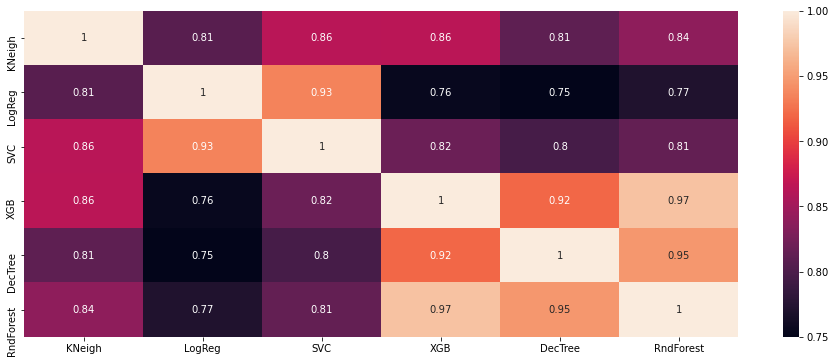

In [158]:
fig, ax = plt.subplots(figsize = (16, 6))
sns.heatmap(pred_test.corr(), annot = True, ax = ax)
plt.show()

There are some differences (correlation < 1). Hence, all models are combined in one big Ensemble Models:

In [161]:
final_model = VotingClassifier(estimators = [('kneigh', k_neighs_fitted), ('logreg', log_reg_fitted),
                                             ('svc', support_vc_fitted), ('xgb', xgb_class_fitted),
                                             ('dectree', dec_tree_fitted), ('rndforest', random_forest_fitted)],
                              voting = 'hard', n_jobs = -1).fit(X_train, y)

## Preprations for submission:

Generate predictions using the tuned model and the test dataset:

In [162]:
final_pred = final_model.predict(X_test)

For submission a DataFrame with the test dataset IDs and the predictions is created:

In [163]:
submission_array = np.array([test_passengerid.to_list(), final_pred.astype("int").tolist()]).T

In [164]:
submission_df = pd.DataFrame(submission_array, columns = ["PassengerId", "Survived"])

In [165]:
submission_df.to_csv("kaggle_titanic_submission.csv", columns = ["PassengerId", "Survived"], index = False)